# Read Data

In [3]:
import pandas as pd

feature_names=["Age", "Workclass", "Final Weight", "Education", "Education-Num", "Marital Status",
               "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
               "Hours per week", "Country", "Income"]

df_train=pd.read_csv("../../data/adult.data",
                     names=feature_names)

df_test=pd.read_csv("../../data/adult.test",
                    skiprows =1,
                    names=feature_names)


# Data prep & problem definition

In [4]:

def df_prep(df):
    df=df.copy()
    LABEL="Income"
    y_train=df[LABEL].replace([" <=50K"," <=50K."," >50K"," >50K."],[0,0,1,1])
    df_X=df.drop(LABEL, axis=1)
    return df_X,y_train

df_X_train,y_train=df_prep(df_train)
df_X_test,y_test=df_prep(df_test)

# Very basic feature/classifier pipeline

In [5]:
# Sorry, I'm that lazy... :)

import numpy as np
from sklearn_pandas import gen_features
from sklearn_pandas import DataFrameMapper
import sklearn.preprocessing as preprocessing

nums=[ ([c],preprocessing.Imputer()) for c in df_X_train.select_dtypes([np.number])]
cats=[ ([c],preprocessing.LabelBinarizer()) for c in df_X_train.select_dtypes(["object"])]

feature_mapper=DataFrameMapper(nums+cats,df_out=True)
feature_mapper

DataFrameMapper(default=False, df_out=True,
        features=[(['Age'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), (['Final Weight'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), (['Education-Num'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), (['C...sparse_output=False)), (['Country'], LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False))],
        input_df=False, sparse=False)

# Grid/Random search  

In [6]:
from sklearn.pipeline import Pipeline
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier

param_dist = {
              # Note n_estimators probably not a true hyperparameter, 
              # in general more is better (aside performance/diminishing returns)
              "classifier__n_estimators": [20],
              "classifier__max_features": ['auto', 'sqrt', 'log2'],
              "classifier__max_depth": [1,2,4,8,16],
              "classifier__min_samples_leaf": [1,8,16],
              "classifier__bootstrap": [True,False],
              "classifier__class_weight": [None,"balanced","balanced_subsample"],
              "classifier__n_jobs":[-1],
              "classifier__criterion" :['gini', 'entropy']
             }

classifier = RandomForestClassifier(random_state=42)

pipeline=Pipeline([('featurize', feature_mapper),
                   ('classifier',classifier)])

In [7]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split

# Quick grid search
CV=3
N_ITER=5

search_cv = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                   n_jobs=1,
                                   n_iter=N_ITER,
                                   scoring="roc_auc",
                                   error_score=0,cv=CV,verbose=5,
                                   
                                   #will not be default for sklearn .021
                                   return_train_score=True)

# Use subsample for grid search
GRID_TRAIN_PERC=.1

(X_train_grid,_,y_train_grid,_)=train_test_split(df_X_train,
                                                 y_train,
                                                 test_size=GRID_TRAIN_PERC,
                                                 random_state=42,
                                                 stratify=y_train)

In [8]:
search_cv.fit(X_train_grid,y_train_grid)

clf=search_cv.best_estimator_
clf

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] classifier__n_jobs=-1, classifier__n_estimators=20, classifier__min_samples_leaf=8, classifier__max_features=auto, classifier__max_depth=16, classifier__criterion=entropy, classifier__class_weight=balanced_subsample, classifier__bootstrap=True 
[CV]  classifier__n_jobs=-1, classifier__n_estimators=20, classifier__min_samples_leaf=8, classifier__max_features=auto, classifier__max_depth=16, classifier__criterion=entropy, classifier__class_weight=balanced_subsample, classifier__bootstrap=True, score=0.90904032516501, total=   1.6s
[CV] classifier__n_jobs=-1, classifier__n_estimators=20, classifier__min_samples_leaf=8, classifier__max_features=auto, classifier__max_depth=16, classifier__criterion=entropy, classifier__class_weight=balanced_subsample, classifier__bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  classifier__n_jobs=-1, classifier__n_estimators=20, classifier__min_samples_leaf=8, classifier__max_features=auto, classifier__max_depth=16, classifier__criterion=entropy, classifier__class_weight=balanced_subsample, classifier__bootstrap=True, score=0.9089220757747544, total=   1.8s
[CV] classifier__n_jobs=-1, classifier__n_estimators=20, classifier__min_samples_leaf=8, classifier__max_features=auto, classifier__max_depth=16, classifier__criterion=entropy, classifier__class_weight=balanced_subsample, classifier__bootstrap=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV]  classifier__n_jobs=-1, classifier__n_estimators=20, classifier__min_samples_leaf=8, classifier__max_features=auto, classifier__max_depth=16, classifier__criterion=entropy, classifier__class_weight=balanced_subsample, classifier__bootstrap=True, score=0.9059367846936481, total=   1.7s
[CV] classifier__n_jobs=-1, classifier__n_estimators=20, classifier__min_samples_leaf=8, classifier__max_features=log2, classifier__max_depth=2, classifier__criterion=entropy, classifier__class_weight=balanced_subsample, classifier__bootstrap=False 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s


[CV]  classifier__n_jobs=-1, classifier__n_estimators=20, classifier__min_samples_leaf=8, classifier__max_features=log2, classifier__max_depth=2, classifier__criterion=entropy, classifier__class_weight=balanced_subsample, classifier__bootstrap=False, score=0.8616899986750601, total=   1.3s
[CV] classifier__n_jobs=-1, classifier__n_estimators=20, classifier__min_samples_leaf=8, classifier__max_features=log2, classifier__max_depth=2, classifier__criterion=entropy, classifier__class_weight=balanced_subsample, classifier__bootstrap=False 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.0s remaining:    0.0s


[CV]  classifier__n_jobs=-1, classifier__n_estimators=20, classifier__min_samples_leaf=8, classifier__max_features=log2, classifier__max_depth=2, classifier__criterion=entropy, classifier__class_weight=balanced_subsample, classifier__bootstrap=False, score=0.8581907614717947, total=   1.2s
[CV] classifier__n_jobs=-1, classifier__n_estimators=20, classifier__min_samples_leaf=8, classifier__max_features=log2, classifier__max_depth=2, classifier__criterion=entropy, classifier__class_weight=balanced_subsample, classifier__bootstrap=False 
[CV]  classifier__n_jobs=-1, classifier__n_estimators=20, classifier__min_samples_leaf=8, classifier__max_features=log2, classifier__max_depth=2, classifier__criterion=entropy, classifier__class_weight=balanced_subsample, classifier__bootstrap=False, score=0.854446481896872, total=   1.7s
[CV] classifier__n_jobs=-1, classifier__n_estimators=20, classifier__min_samples_leaf=16, classifier__max_features=auto, classifier__max_depth=8, classifier__criterion=e

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   32.8s finished


Pipeline(memory=None,
     steps=[('featurize', DataFrameMapper(default=False, df_out=True,
        features=[(['Age'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), (['Final Weight'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), (['Education-Num'], Imputer(ax...timators=20, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])

# Eval Grid Search results

In [9]:
eval_cv_metric="mean_test_score"
train_cv_metric="mean_train_score"
cv_results_df=pd.DataFrame(search_cv.cv_results_).sort_values(by='rank_test_score')

             
cv_results_df["dif_test_train"]=cv_results_df[train_cv_metric]-cv_results_df[eval_cv_metric]

cv_results_df.fillna("None",inplace=True)

## mean_test_score,dif_test_train vs parameters (numeric)

C:\tools\Anaconda3\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
No handles with labels found to put in legend.
No handles with labels found to put in legend.
C:\tools\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])
C:\Users\rquintino\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


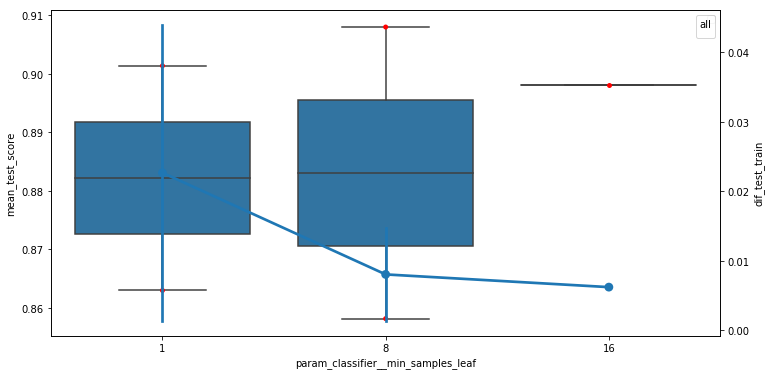

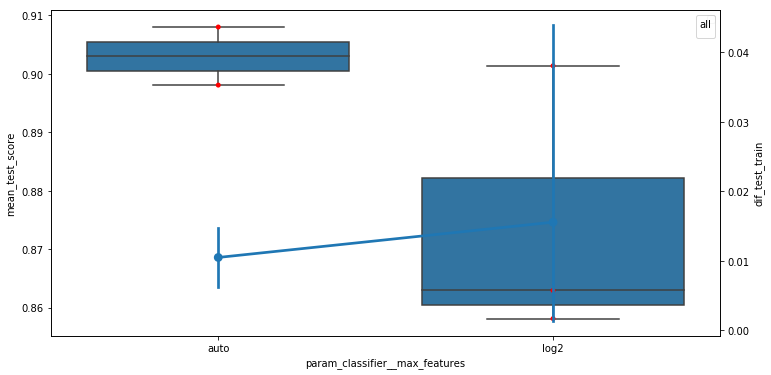

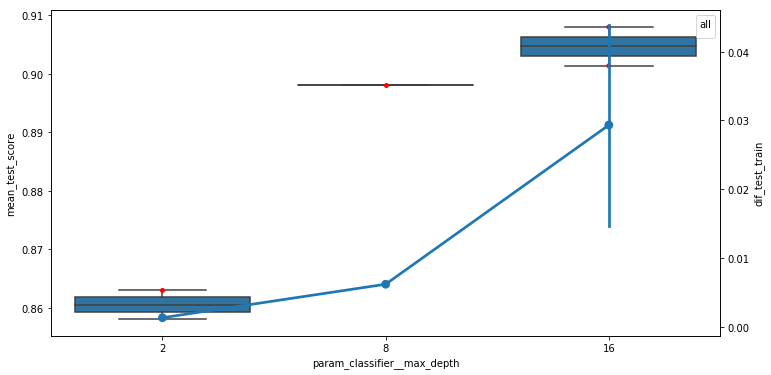

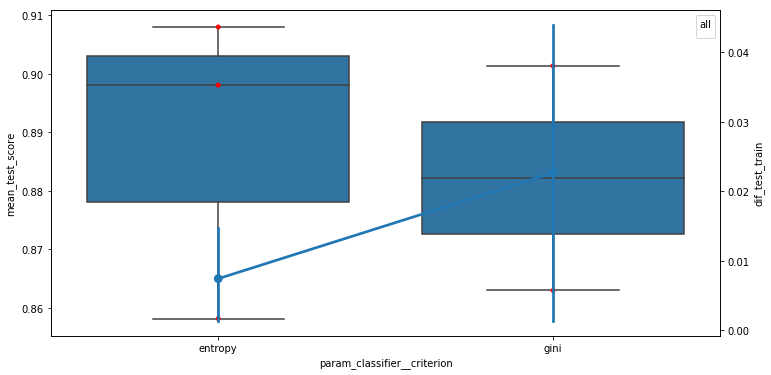

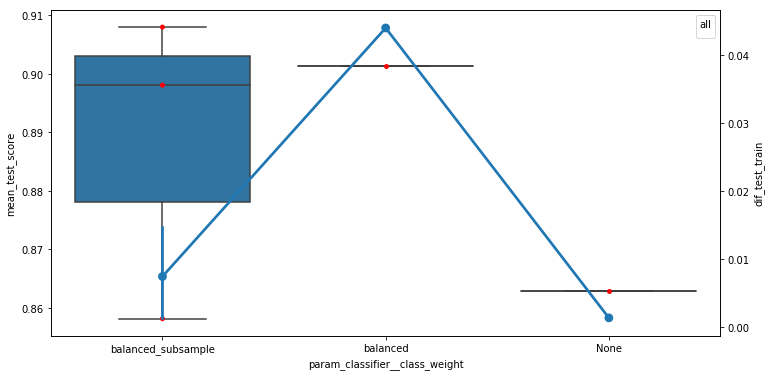

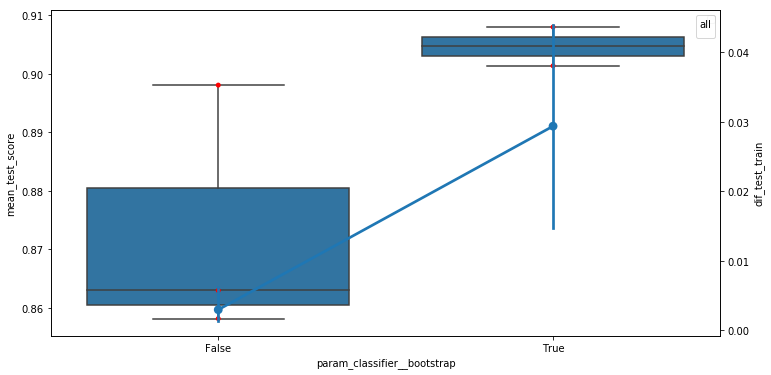

In [10]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.display import display as display, Markdown

score_result=eval_cv_metric
score_result2="dif_test_train"
split_col=""

display(Markdown("## %s,%s vs parameters (numeric)"%(score_result,score_result2)))

all=cv_results_df

all["all"]=""

if not split_col in all.keys():
     split_col="all"

axis=0
for col in all.columns:
    if col.startswith("param_") and len(all[col].unique())>1:
        plt.figure(figsize=(12,6))


        sns.boxplot(x=col, y=score_result, hue=split_col,data=all)
        sns.swarmplot(x=col, y=score_result, color="red",data=all)
        plt.legend()
        ax2 = plt.twinx()
        sns.pointplot(x=col, y=score_result2,hue=split_col,ax=ax2, data=all)


# Full fit (more estimators & full train set)

In [11]:
import sklearn
full_clf=sklearn.clone(clf)
full_clf.set_params(classifier__n_estimators=500)

full_clf.fit(df_X_train,y_train)
full_clf

Pipeline(memory=None,
     steps=[('featurize', DataFrameMapper(default=False, df_out=True,
        features=[(['Age'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), (['Final Weight'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), (['Education-Num'], Imputer(ax...imators=500, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])

# Model eval (test set)

In [12]:
from sklearn.metrics import roc_curve, auc

y_score = full_clf.predict_proba(df_X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,y_score)
roc_auc= auc(fpr, tpr)

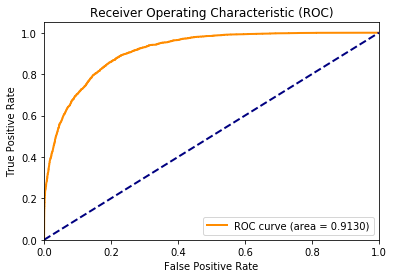

In [13]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Save Model (joblib)

In [14]:
import os
import joblib

def save_model(pipeline,model_id):
    
    os.makedirs(f"../../models/",exist_ok=True)
    
    save_path=f"../../models/{model_id}.pickle"
    joblib.dump(pipeline,save_path)
        
    return save_path
   
save_model(full_clf,"adult_randomforest")


'../../models/adult_randomforest.pickle'